In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd


from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
#from skimage.morphology import label
from PIL import ImageFile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf
from glob import glob        
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from numpy import reshape
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm
import random
# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:

train_path = "/kaggle/input/covid-pneumonia-dataset/Three_Class/train"
test_path = "/kaggle/input/covid-pneumonia-dataset/Three_Class/test"
val_path = "/kaggle/input/covid-pneumonia-dataset/Three_Class/validation"

def displayer(X_tr, X_tr_ae):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(X_tr[i].reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(X_tr_ae[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [4]:
dsize =(64, 64)

labels = {"normal":0} # "pneumonia":1

In [5]:
def load_images(dir_path, labels, dsize = (32, 32)):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize,color_mode= 'grayscale')
            X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            y_image.append(Id)
    return X_image, y_image

def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='gray')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

In [6]:
X_train_org, y_train = load_images(train_path, labels, dsize = dsize)

X_test_org, y_test = load_images(test_path, labels, dsize = dsize)

X_val_org, y_val = load_images(val_path, labels, dsize = dsize)

100%|██████████| 50/50 [00:00<00:00, 169.95it/s]


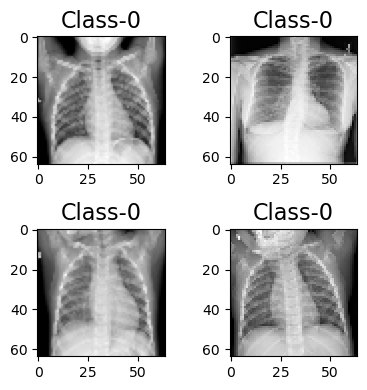

In [7]:
display_images(X_train_org, y_train, figure_row = 2, figure_cols=2)

In [8]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32').reshape(64,64)
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

In [9]:
normalize = True

X_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", X_train.shape)

X_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", X_val.shape)

X_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", X_test.shape)

100%|██████████| 500/500 [00:00<00:00, 13947.08it/s]


Shape of X_train: (500, 64, 64)


100%|██████████| 50/50 [00:00<00:00, 17866.35it/s]


Shape of X_val: (50, 64, 64)


100%|██████████| 100/100 [00:00<00:00, 17993.58it/s]

Shape of X_test: (100, 64, 64)


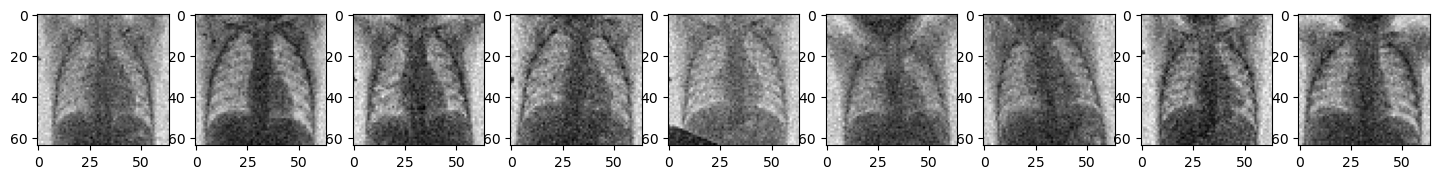

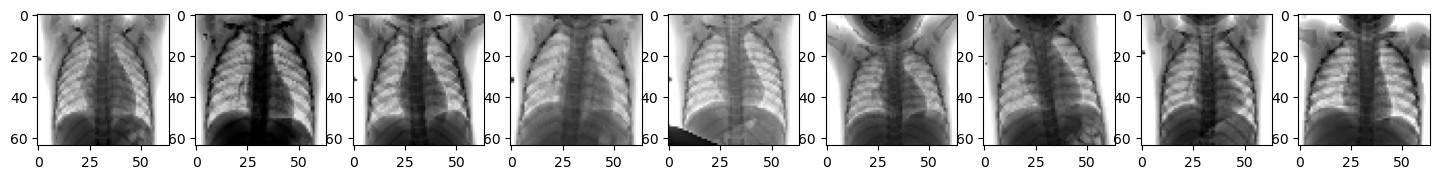

In [10]:

#Adding noise
def add_noise(image):
    row,col= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss*0.1
    return noisy
X_train_noisy= []
X_test_noisy = []
X_val_noisy = []

for img in X_train:
    noisy_img = add_noise(img)
    X_train_noisy.append(noisy_img)
for img in X_test:
    noisyt_img = add_noise(img)
    X_test_noisy.append(noisyt_img)
    
for img in X_val:
    noisytt_img = add_noise(img)
    X_val_noisy.append(noisytt_img)

X_train_noisy= np.array(X_train_noisy)
X_test_noisy= np.array(X_test_noisy)
X_val_noisy= np.array(X_val_noisy)

#Displaying images with noise
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(X_train_noisy[i].reshape(64, 64,1), cmap="binary")   
plt.show()
#Displaying images without noise
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(X_train[i].reshape(64, 64,1), cmap="binary")
    
plt.show()





In [12]:
# from time import time

import argparse

from operator import mul, sub
from skimage.util.shape import *
#from skimage.util import pad
from functools import reduce
from math import floor, sqrt, log10
from scipy.sparse.linalg import svds
import timeit
import sys


patch_size = 4 #8

sigma = 20                 # Noise standard dev.

window_shape = (patch_size, patch_size)    # Patches' shape
window_stride = 4                  # Patches' step
dict_ratio = 0.1            # Ratio for the dictionary (training set).
num_dict=1100   
ksvd_iter = 1  
max_sparsity = 1
max_resize_dim = 64 #512
dict_train_blocks = 32500 #65000



#-------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------- PATCH CREATION -------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

def patch_matrix_windows(img, stride):
    # we return an array of patches(patch_size X num_patches)
    patches = view_as_windows(img, window_shape, step=stride)  # shape = [patches in image row,patches in image col,rows in patch,cols in patch]
    # size of cond_patches = patch size X number of patches
    cond_patches = np.zeros((reduce(mul, patches.shape[2:4]), reduce(mul, patches.shape[0:2])))
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            cond_patches[:, j+patches.shape[1]*i] = np.concatenate(patches[i, j], axis=0)
    return cond_patches, patches.shape


def reconstruct_image(patch_final, noisy_image):
    img_out = np.zeros(noisy_image.shape)
    weight = np.zeros(noisy_image.shape)
    num_blocks = noisy_image.shape[0] - patch_size + 1
    for l in range(patch_final.shape[1]):
        i, j = divmod(l, num_blocks)
        temp_patch = patch_final[:, l].reshape(window_shape)
        # img_out[i, j] = temp_patch[1, 1]
        img_out[i:(i+patch_size), j:(j+patch_size)] = img_out[i:(i+patch_size), j:(j+patch_size)] + temp_patch
        weight[i:(i+patch_size), j:(j+patch_size)] = weight[i:(i+patch_size), j:(j+patch_size)] + np.ones(window_shape)      

    # img_out = img_out/weight
    img_out = (noisy_image+0.034*sigma*img_out)/(1+0.034*sigma*weight)


    print('max: ',np.max(img_out))

    return img_out


#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------ APPROXIMATION PURSUIT METHOD : -----------------------------------------#
#------------------------------------- MULTI-CHANNEL ORTHOGONAL MATCHING PURSUIT -----------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

def omp(D, data, sparsity):
    max_error = sqrt(((sigma**1.15)**2)*data.shape[0])
    # max_coeff = D.shape[0]/2
    max_coeff = sparsity


    sparse_coeff = np.zeros((D.shape[1],data.shape[1]))
    tot_res = 0
    for i in range(data.shape[1]):
        count = floor((i+1)/float(data.shape[1])*100)
        sys.stdout.write("\r- Sparse coding : Channel : %d%%" % count)
        sys.stdout.flush()
        
        x = data[:,i]
        res = x
        atoms_list = []
        res_norm = np.linalg.norm(res)
        temp_sparse = np.zeros(D.shape[1])

        while len(atoms_list) < max_coeff: #and res_norm > max_error:
            proj = D.T.dot(res)
            i_0 = np.argmax(np.abs(proj))
            atoms_list.append(i_0)

            temp_sparse = np.linalg.pinv(D[:,atoms_list]).dot(x)
            res = x - D[:,atoms_list].dot(temp_sparse)
            res_norm = np.linalg.norm(res)

        tot_res += res_norm
        if len(atoms_list) > 0:
            sparse_coeff[atoms_list, i] = temp_sparse
#     print('\n',tot_res)
#     print ('\r- Sparse coding complete.\n')

    return sparse_coeff

#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------- DICTIONARY METHODS -------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#


def dict_initiate(train_noisy_patches, dict_size):
    # dictionary intialization
    
    indexes = np.random.random_integers(0, train_noisy_patches.shape[1]-1, dict_size)   # indexes of patches for dictionary elements
    dict_init = np.array(train_noisy_patches[:, indexes])            # each column is a new atom

    # dictionary normalization
    dict_init = dict_init - dict_init.mean()
    temp = np.diag(pow(np.sqrt(np.sum(np.multiply(dict_init,dict_init),axis=0)), -1))
    dict_init = dict_init.dot(temp)    
    basis_sign = np.sign(dict_init[0,:])
    dict_init = np.multiply(dict_init, basis_sign)

#     print( 'Shape of dictionary : ' , str(dict_init.shape) + '\n')
#     # cv2.namedWindow('dict', cv2.WINDOW_NORMAL)
#     # cv2.imshow('dict',dict_init.astype('double'))

    return dict_init


def dict_update(D, data, matrix_sparse, atom_id):
    indices = np.where(matrix_sparse[atom_id, :] != 0)[0]
    D_temp = D
    sparse_temp = matrix_sparse[:,indices]

    if len(indices) > 1:
        sparse_temp[atom_id,:] = 0

        matrix_e_k = data[:, indices] - D_temp.dot(sparse_temp)
        u, s, v = svds(np.atleast_2d(matrix_e_k), 1)
        D_temp[:, atom_id] = u[:, 0]
        matrix_sparse[atom_id, indices] = s.dot(v)

    return D_temp, matrix_sparse

#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------- K-SVD ALGORITHM -------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

def k_svd(train_noisy_patches, dict_size, sparsity):

    dict_init = dict_initiate(train_noisy_patches, dict_size)

    D = dict_init

    matrix_sparse = np.zeros((D.T.dot(train_noisy_patches)).shape)         # initializing spare matrix
    num_iter = ksvd_iter
#     print ('\nK-SVD, with residual criterion.')
#     print ('-------------------------------')

    for k in range(num_iter):
        print ("Stage " , str(k+1) , "/" , str(num_iter) , "...")

        matrix_sparse = omp(D, train_noisy_patches, sparsity)

        count = 1

        dict_elem_order = np.random.permutation(D.shape[1])

        for j in dict_elem_order:
            r = floor(count/float(D.shape[1])*100)
            sys.stdout.write("\r- Dictionary updating : %d%%" % r)
            sys.stdout.flush()
            
            D, matrix_sparse = dict_update(D, train_noisy_patches, matrix_sparse, j)
            count += 1
#         print ('\r- Dictionary updating complete.\n')

    return D, matrix_sparse


#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------ DENOISING METHOD -------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#


def denoising(noisy_image, dict_size, sparsity):

    # 1. Form noisy patches.
    padded_noisy_image = np.pad(noisy_image, pad_width=window_shape, mode='symmetric')

    # dictionary intialization
    
    poss_patches = (noisy_image.shape[0]-patch_size + 1) * (noisy_image.shape[1]-patch_size +1)
    stride = floor(poss_patches/dict_train_blocks)
    if stride<1:
        stride = 1
#     print('img_patches: ',poss_patches,'train_stride: ',stride)
    stride = 2
    train_noisy_patches, train_noisy_patches_shape = patch_matrix_windows(padded_noisy_image, stride)
    train_data_mean = train_noisy_patches.mean()
    train_noisy_patches = train_noisy_patches - train_data_mean                                                 # X(size mxp) = D(size mxn) x matrix_sparse(size nxp)

    # 3. Compute K-SVD.
    start = timeit.default_timer()
    dict_final, sparse_init = k_svd(train_noisy_patches, dict_size, sparsity)
    # stop = timeit.default_timer()
    # print ("Calculation time : " , str(stop - start) , ' seconds.')

    noisy_patches, noisy_patches_shape = patch_matrix_windows(padded_noisy_image, stride=1)
    data_mean = noisy_patches.mean()
    noisy_patches = noisy_patches - data_mean


    # start = timeit.default_timer()
    sparse_final = omp(dict_final, noisy_patches, sparsity)

    # 4. Reconstruct the image.
    patches_approx = dict_final.dot(sparse_final) + data_mean

    padded_denoised_image = reconstruct_image(patches_approx, padded_noisy_image)
    # patches_approx = patches_approx.reshape(noisy_patches.shape[1], *(patch_size,patch_size))
    # padded_denoised_image = reconstruct_from_patches_2d(patches_approx, (padded_noisy_image.shape[0]//2, padded_noisy_image.shape[1]//2))

    stop = timeit.default_timer()
#     print ("Calculation time : " , str(stop - start) , ' seconds.')

    shrunk_0, shrunk_1 = tuple(map(sub, padded_denoised_image.shape, window_shape))
    denoised_image = np.abs(padded_denoised_image)[window_shape[0]:shrunk_0, window_shape[1]:shrunk_1]

    return denoised_image, stop - start



In [ ]:
#image = cv2.imread('/kaggle/input/prova-image/Prova.jpg', 0)
noisy_psnr_list = []
final_psnr_list = []
noisy_image_list = []

max_init_size = max(X_train[0].shape[0], X_train[0].shape[1])
resize_ratio = 64
denoise_image_list = []
for image in X_train[:100]:
    image = image.reshape(64, 64)  * 1.0

    if resize_ratio < 1:
        image = cv2.resize(image, None, fx=resize_ratio, fy=resize_ratio, interpolation=cv2.INTER_AREA)

    noise_layer = np.random.normal(0, 1 ^ 2, image.shape).reshape(image.shape).astype(int)
    noisy_image = image + noise_layer*0.1
    #noisy_image = add_noise(image)
    noisy_image*0.3
    noisy_image_list.append(noisy_image)


    # for max_sparsity in range(1,11,1):
    #print('num_dict:',num_dict,'max_sparsity:',max_sparsity)
    denoised_image, calc_time = denoising(noisy_image, dict_size=num_dict, sparsity=max_sparsity)
    denoise_image_list.append(denoised_image)
    noisy_psnr = 20*log10(np.amax(image)) - 10*log10(pow(np.linalg.norm(image - noisy_image), 2)/noisy_image.size)
    final_psnr = 20*log10(np.amax(image)) - 10*log10(pow(np.linalg.norm(image - denoised_image), 2)/denoised_image.size)
    noisy_psnr_list.append(noisy_psnr)
    final_psnr_list.append(final_psnr)
 

Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.300275461929312
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.4160833941707744
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.7521627729299063
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.5041997751747669
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.4549162202543775
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.440345601874895
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.5806078832012262
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.3439573313857491
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.4266520597628376
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.3277924627854722
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.4512149150533868
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.4567600741973377
Stage  1 / 1 ...
- Sparse coding : Channel : 100%max:  1.422927505388396
Stage  1 / 1 ...
- Sparse coding : Channe

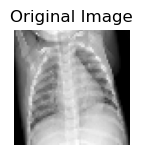

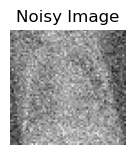

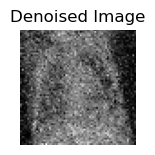

In [26]:
import matplotlib.pyplot as plt

# Display the original image
plt.figure(figsize=(1.5, 1.5))
plt.imshow(X_train[49],cmap='gray')
plt.title('Original Image')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the noisy image
plt.figure(figsize=(1.5, 1.5))
plt.imshow(noisy_image_list[49],cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.show()

# Display the denoised image
plt.figure(figsize=(1.5, 1.5))
plt.imshow(denoise_image_list[49],cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()

In [30]:
noisy_psnr1 = noisy_psnr_list.copy()
final__psnr1 = final_psnr_list.copy()
noisy_image1 = noisy_image_list.copy()

In [66]:
noisy_image_list=noisy_image1.copy()

# Auto-encoder

In [29]:
def autoencoder():
    
    input_img = Input(shape=(64,64,1), name='image_input')
    
    #enoder 
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [30]:
model= autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 32, 32, 64)        0     

In [37]:
model1= autoencoder()


In [33]:

# Assuming denoise_image_list is your list of image arrays
reshaped_images = []
for image_array in denoise_image_list:
    reshaped_image = np.reshape(image_array, (64, 64, 1))
    reshaped_images.append(reshaped_image)

reshaped_images = np.array(reshaped_images)



In [53]:


# Assuming denoise_image_list is your list of image arrays
reshaped_images1 = []
for image_array in noisy_image_list:
    reshaped_image1 = np.reshape(image_array, (64, 64, 1))
    reshaped_images1.append(reshaped_image1)

reshaped_images1 = np.array(reshaped_images1)


### Autoencoder only

In [59]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(reshaped_images1[:40],X_train[:40], epochs=100, batch_size=32, validation_data=(reshaped_images1[40:45],X_train[40:45]), callbacks=[early_stopping])

### Autoencoder+SVD

In [34]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(reshaped_images[:40],X_train[:40], epochs=100, batch_size=32, validation_data=(reshaped_images[40:45],X_train[40:45]), callbacks=[early_stopping])

Epoch 1/100
2/2 [==============================] - 9s 536ms/step - loss: 0.7011 - val_loss: 0.6896
Epoch 2/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6841 - val_loss: 0.6801
Epoch 3/100
2/2 [==============================] - 0s 58ms/step - loss: 0.6756 - val_loss: 0.6725
Epoch 4/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6702 - val_loss: 0.6566
Epoch 5/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6469 - val_loss: 0.6385
Epoch 6/100
2/2 [==============================] - 0s 44ms/step - loss: 0.6268 - val_loss: 0.6184
Epoch 7/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6231 - val_loss: 0.6240
Epoch 8/100
2/2 [==============================] - 0s 31ms/step - loss: 0.6148 - val_loss: 0.6345
Epoch 9/100
2/2 [==============================] - 0s 30ms/step - loss: 0.6223 - val_loss: 0.6099
Epoch 10/100
2/2 [==============================] - 0s 30ms/step - loss: 0.6044 - val_loss: 0.6019
Epoch 11/100
2/2 [

In [ ]:
xtrain= train_df[80:]

1/1 [==============================] - 0s 20ms/step


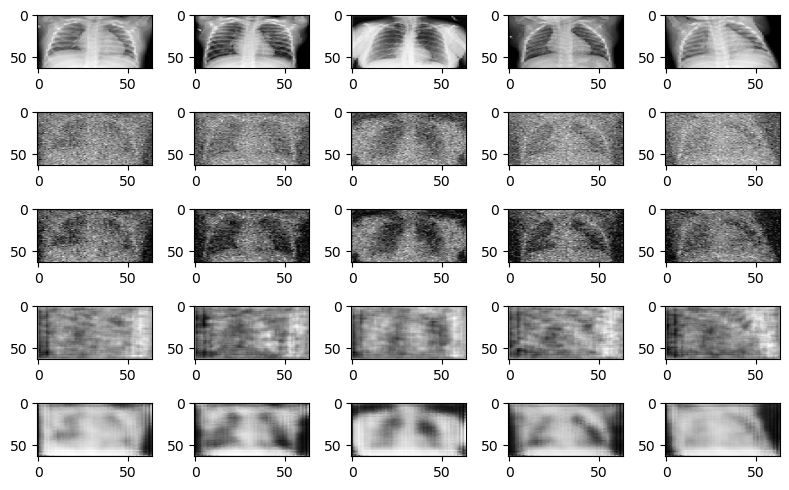

In [56]:
import cv2

pred= model.predict(reshaped_images[45:])
pred1 = model1.predict(reshaped_images1[45:])


##### PSNR

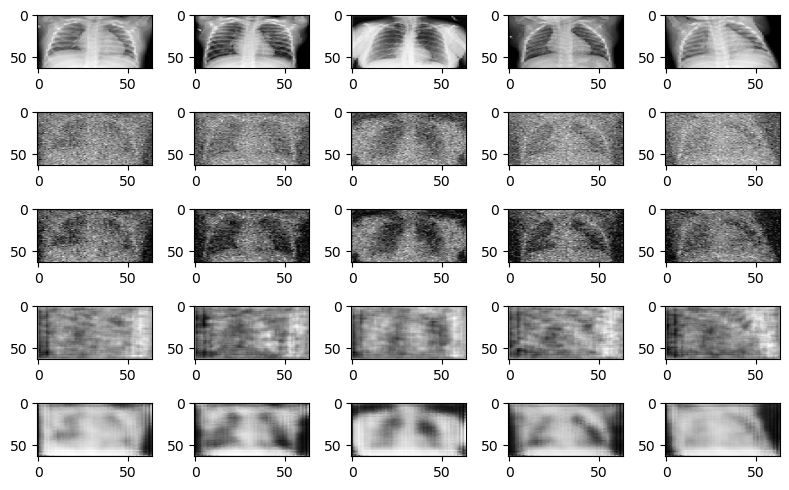

In [67]:


def plot_predictions(X_true, X_pred, X_pred1, X_noise, SVD):
    f, ax = plt.subplots(5, 5)
    f.set_size_inches(8, 5)
    
    for i in range(5):
        ax[0][i].imshow(np.reshape(X_true[i], (64, 64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(X_noise[i], (64, 64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(SVD[i], (64, 64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(np.reshape(X_pred1[i], (64, 64)), aspect='auto', cmap='gray')
        ax[4][i].imshow(np.reshape(X_pred[i], (64, 64)), aspect='auto', cmap='gray')
    
    plt.tight_layout()

    # Save the figure as an image
    plt.savefig("output_images.png")  # Specify the filename and format

# Call the function with your data
plot_predictions(X_train[45:50], pred, pred1, reshaped_images1[45:], reshaped_images[45:])


In [ ]:
from math import log10, sqrt 
  
def PSNR(original, denoiced): 
    mse = np.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

In [ ]:
pred,pred1,reshaped_images1[45:],reshaped_images[45:]

In [66]:
from skimage.metrics import structural_similarity as ssim

ssimArr = []

for idx, each in enumerate(pred):
    ssimArr.append(ssim(each, X_train[idx].reshape(64,64,1), data_range=1.0 - 0.0, multichannel=True,channel_axis =-1 ))

np.mean(ssimArr)

0.3358066

In [65]:
from skimage.metrics import structural_similarity as ssim

ssimArr = []

for idx, each in enumerate(pred1):
    ssimArr.append(ssim(each, X_train[idx].reshape(64,64,1), data_range=1.0 - 0.0, multichannel=True,channel_axis =-1 ))

np.mean(ssimArr)

0.11241575

In [63]:
from skimage.metrics import structural_similarity as ssim

ssimArr = []

for idx, each in enumerate(reshaped_images1[45:]):
    ssimArr.append(ssim(each, X_train[idx].reshape(64,64,1), data_range=1.0 - 0.0, multichannel=True,channel_axis =-1 ))

np.mean(ssimArr)

0.1053212159182872

In [64]:
from skimage.metrics import structural_similarity as ssim

ssimArr = []

for idx, each in enumerate(reshaped_images[45:]):
    ssimArr.append(ssim(each, X_train[idx].reshape(64,64,1), data_range=1.0 - 0.0, multichannel=True,channel_axis =-1 ))

np.mean(ssimArr)

0.17019039946380496